# Import dependencies
First, you may need to install 
* NumPy - `pip install numpy`,
* Matplotlib - `pip install matplotlib`,
* PyTorch - `pip install torch torchvision`.

Then you should be able to import all required dependencies.

In [65]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.datasets import MNIST, USPS
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.distributions import MultivariateNormal

Add parent directory to path to access sibling modules

In [66]:
if '..' not in sys.path:
    sys.path.append('..')

In [67]:
%load_ext autoreload
%autoreload 1

%aimport neural_ot.data_loading, neural_ot.model, neural_ot.train
from neural_ot.data_loading import ZipLoader
from neural_ot.model import NeuralOT, Unflatten, Vector
from neural_ot.train import train

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global variables
First, we set `DEVICE` and `IS_CUDA` global variables.

In [68]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    IS_CUDA = True
else:
    DEVICE = torch.device('cpu')
    IS_CUDA = False

Second, we download MNIST and USPS datasets using `torchvision.datasets`. We normalize intensities from the default interval $[0, 1]$ to the interval $[-1, 1]$ via linear transformation $I' = (I - 0.5) / 0.5$ (as it was done in the original paper). Also for the generative modeling task we concatenate train and test sets to the single dataset, held in global variable `mnist`. The same is done with `usps`.

In [69]:
h, w = 16, 16
mnist_tr = transforms.Compose([transforms.Resize((h, w)),
                               transforms.ToTensor(), 
                               transforms.Normalize([.5], [.5]),
                               ])
usps_tr  = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize([.5], [.5]),
                               ])

If we want to study MNIST $\to$ USPS mapping, just uncomment the lines below. They determine, which dataset is the source distribution and which is the target one.

In [70]:
mnist_train = MNIST('data/mnist', download=True, transform=mnist_tr, train=True)
mnist_test = MNIST('data/mnist', download=True, transform=mnist_tr, train=False)
mnist = ConcatDataset([mnist_train, mnist_test])

usps_train = USPS('data/usps', download=True, transform=usps_tr, train=True)
usps_test = USPS('data/usps', download=True, transform=usps_tr, train=False)
usps = ConcatDataset([usps_train, usps_test])

source = usps
target = mnist

# # We can swap the source and the target
# source = mnist
# target = usps

In [71]:
BATCH_SIZE = 300
N_BATCHES_PER_EPOCH = 10
N_WORKERS = 4 if os.name != 'nt' else 0 # no threads for windows :c

In [72]:
paired_loader = ZipLoader(source, target, batch_size=BATCH_SIZE, n_batches=N_BATCHES_PER_EPOCH, 
                          pin_memory=IS_CUDA, return_idx=True, num_workers=N_WORKERS)

In [73]:
for (x_idx, x), (y_idx, y) in paired_loader:
    print(x_idx.shape, x.shape, y_idx.shape, y.shape)
    break

torch.Size([300]) torch.Size([300, 1, 16, 16]) torch.Size([300]) torch.Size([300, 1, 16, 16])


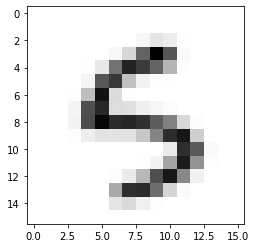

In [74]:
plt.imshow(y[0, 0].numpy(), cmap="Greys")

We parametrized the $u$ and $v$ functions as `Vector` objects as they were used in the original article. Nevertheless, one can use neural networks to treat $u$ and $v$ as vectors. In this case don't forget to uncomment corresponding lines.

In [75]:
## Parametrization via neural network
# source_dual_net = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(h * w, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 1),
#     nn.Flatten(start_dim=0)
# )

## Parametrization via vector
source_dual_net = Vector(initial=1e-2 * torch.randn(len(source)))

## Parametrization via neural network
# target_dual_net = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(h * w, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 1024),
#     nn.ReLU(),
#     nn.BatchNorm1d(1024),
#     nn.Linear(1024, 1),
#     nn.Flatten(start_dim=0)
# )

## Parametrization via vector
target_dual_net = Vector(initial=1e-2 * torch.randn(len(target)))

source_to_target_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(h * w, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 500),
    nn.ReLU(),
    nn.BatchNorm1d(500),
    nn.Linear(500, h * w),
    Unflatten(h, w),
    nn.Tanh()
)

In [76]:
# ot = torch.load('generative_model.pth')
# ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
#               regularization_mode='l2', regularization_parameter=0.05, 
#               from_discrete=False, to_discrete=False).to(DEVICE)

## In the case we use vectors, we are working in the discrete setting
ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
              regularization_mode='l2', regularization_parameter=0.05, 
              from_discrete=True, to_discrete=True).to(DEVICE)

In [77]:
# plan_optimizer = Adam(ot.parameters(), lr=1e-3)
# plan_scheduler = MultiStepLR(plan_optimizer, [20, 75])

# # The training procedure is changed too
plan_optimizer = Adam(ot.parameters(), lr=1.)
plan_scheduler = MultiStepLR(plan_optimizer, [100, 400, 800])

In [78]:
losses = train(ot.plan_criterion, plan_optimizer, paired_loader, n_epochs=1000, device=DEVICE, 
               scheduler=plan_scheduler)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [40:17<00:00,  2.42s/it]


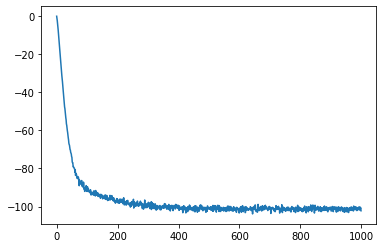

In [79]:
plt.plot(losses)

In [80]:
mapping_optimizer = Adam(ot.parameters(), lr=1e-4)
mapping_scheduler = MultiStepLR(plan_optimizer, [100, 400, 800])

In [81]:
mapping_losses = train(ot.mapping_criterion, mapping_optimizer, paired_loader, n_epochs=500, device=DEVICE, 
                       scheduler=mapping_scheduler)

  0%|                                                                                                                                                                                                             | 0/500 [00:00<?, ?it/s]D:\Prog\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [18:32<00:00,  2.2

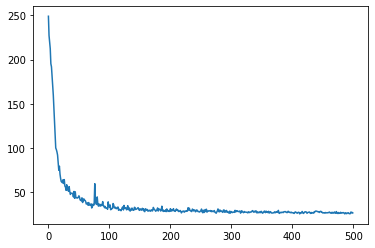

In [82]:
plt.plot(mapping_losses)

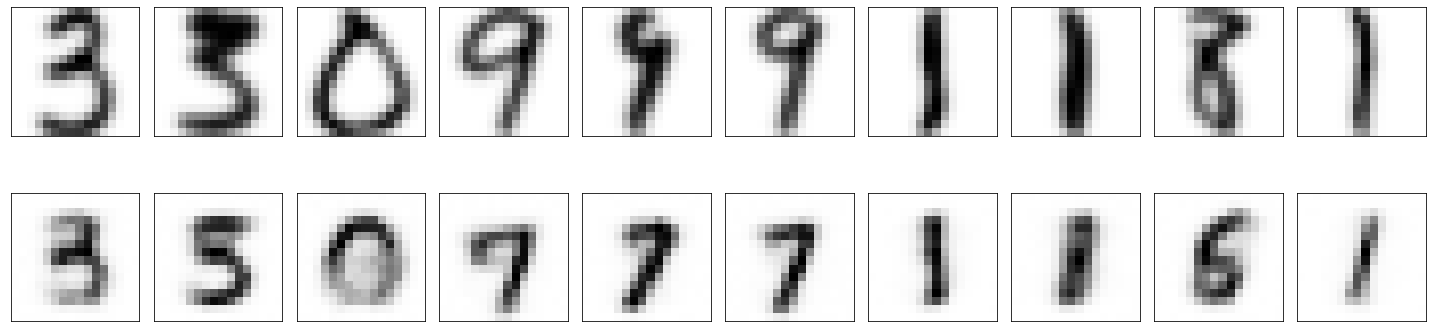

In [83]:
n_samples = 10
idx = torch.multinomial(torch.ones(len(source)), n_samples)
ot.eval().cpu()

fig, axes = plt.subplots(2, n_samples, figsize=(20, 6))

for i in range(n_samples):
    img = source[idx[i]][0]
    axes[0, i].imshow(img.squeeze(), cmap="Greys")
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    mapped = ot.map(img.reshape(1, 1, h, w))
    axes[1, i].imshow(mapped.squeeze().detach().numpy(), cmap="Greys")
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    
plt.tight_layout()
fig.savefig("mappings.png")

In [84]:
X_source, y_source = [], []
for i in tqdm(range(len(source)), "Source"):
    X, y = source[i]
    X_source.append(X)
    y_source.append(y)

X_source = torch.cat(X_source).reshape(-1, h*w).numpy()
y_source = np.array(y_source)

X_target, y_target = [], []
for i in tqdm(range(len(target)), "Target"):
    X, y = target[i]
    X_target.append(X)
    y_target.append(y)

X_target = torch.cat(X_target).reshape(-1, h*w).numpy()
y_target = np.array(y_target)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_source, y_source)

y_pred = clf.predict(X_target)
print("1-KNN accuracy: {:.3f}".format(accuracy_score(y_target, y_pred)))

X_source_mapped, y_source_mapped = [], []
for i in tqdm(range(len(source)), "Source -> Target"):
    X, y = source[i]
    mapped = ot.map(X.reshape(1, 1, h, w))
    X_source_mapped.append(mapped.squeeze())
    y_source_mapped.append(y)

X_source_mapped = torch.cat(X_source_mapped).reshape(-1, h*w).detach().numpy()
y_source_mapped = np.array(y_source_mapped)

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_source_mapped, y_source_mapped)

y_pred = clf.predict(X_target)
print("Mapped 1-KNN accuracy: {:.3f}".format(accuracy_score(y_target, y_pred)))

Source -> Target:   2%|██▊                                                                                                                                                                           | 148/9298 [00:00<00:06, 1469.34it/s]

1-KNN accuracy: 0.373


Source -> Target: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9298/9298 [00:05<00:00, 1757.37it/s]


Mapped 1-KNN accuracy: 0.588


In [85]:
torch.save(ot, 'adaptation_model.pth')